# In-Context Learning

In-context learning refers to the ability of a language model to perform a task by conditioning on a prompt that includes a small number of input-output examples, without any parameter updates. This experiment evaluates whether a pretrained language model can perform sentiment classification on financial text using in-context learning alone.

The classification task involves assigning a label — positive, neutral, or negative — to financial news headlines. A subset of the Financial PhraseBank dataset is used, consisting of short, labeled financial sentences.

The model used is Falcon-7B-Instruct, a publicly available large language model optimized for instruction-following tasks. It is accessed through Hugging Face and used in causal language modeling mode for prompt-based completion.

For each test sentence, a prompt is constructed containing nine labeled examples (three per class). The model is asked to predict the sentiment of a new sentence based on these examples. To account for sampling variation, the experiment is repeated over five random seeds, and results are averaged.

Across all runs, the model achieved an average accuracy of approximately 82% and a macro F1 score of approximately 73%. The confusion matrix from the final run showed improved coverage across all classes compared to earlier 5-shot experiments, indicating the effectiveness of balanced prompting for in-context learning in financial classification tasks.


Libraries & Imports

In [1]:
!pip install -q datasets transformers accelerate bitsandbytes

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load Falcon-7B-Instruct
*- Selected because it's open access*

In [2]:
model_name = "tiiuae/falcon-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",        # Automatically assigns GPU/CPU
    torch_dtype=torch.float16,
    load_in_4bit=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Load Finanical PhraseBank and Sample

In [3]:


dataset = load_dataset("financial_phrasebank", "sentences_allagree")
df = pd.DataFrame(dataset['train'])
df = df.rename(columns={"sentence": "text", "label": "true_label"})

label_map = {0: "negative", 1: "neutral", 2: "positive"}
df["label_text"] = df["true_label"].map(label_map)

# Shuffle and sample
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
few_shot = df[:5]
test_set = df[5:25]

# Prompt Builder

This function constructs a prompt for few-shot in-context learning. It formats a series of labeled financial headlines followed by an unlabeled test sentence. Each example follows the pattern: `"headline" → Label`. The final sentence ends with an arrow, prompting the model to complete the sentiment label based on the preceding examples.

In [4]:
def build_prompt(few_shot_df, test_sentence):
    prompt = "Classify the sentiment of each financial headline as Positive, Neutral, or Negative.\n\n"
    for i, row in few_shot_df.iterrows():
        prompt += f"{i+1}. \"{row['text']}\" → {row['label_text'].capitalize()}\n"
    prompt += f"{len(few_shot_df)+1}. \"{test_sentence}\" →"
    return prompt

# Prediction Loop

This loop generates a prediction for each test sentence by inserting it into a prompt with few-shot examples, passing the prompt to the model, and extracting the predicted sentiment from the model’s response. The output is matched to one of the expected labels or marked as "unknown" if no match is found.


In [5]:
def generate_response(prompt, max_tokens=20):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded[len(prompt):].strip().lower()

predictions = []
for i, row in test_set.iterrows():
    prompt = build_prompt(few_shot, row["text"])
    response = generate_response(prompt)
    for label in ["positive", "neutral", "negative"]:
        if label in response:
            predictions.append(label)
            break
    else:
        predictions.append("unknown")

/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


# Evaluation

<ipython-input-6-28cbded608be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["predicted_label_9shot"] = predictions


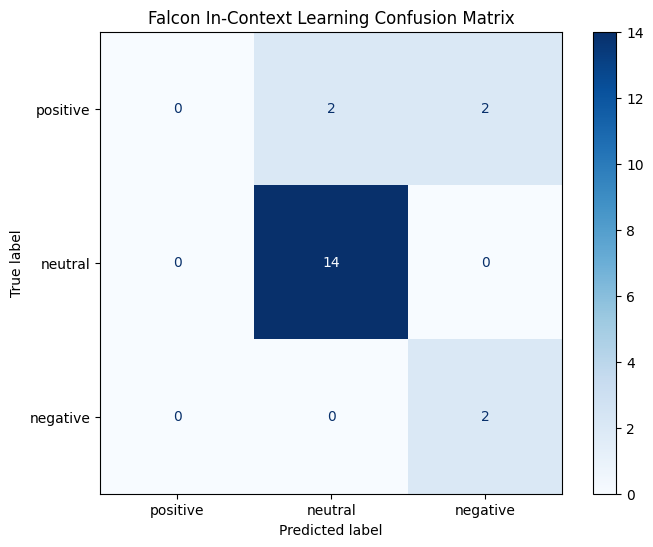

In [6]:
labels = ["positive", "neutral", "negative"]

# Store predictions into the DataFrame
test_set["predicted_label_9shot"] = predictions

# Extract true and predicted labels
true = test_set["label_text"]
pred = test_set["predicted_label_9shot"]

# Compute and display confusion matrix
cm = confusion_matrix(true, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True)
plt.title("Falcon In-Context Learning Confusion Matrix")
plt.show()


## Results

The initial evaluation using a single 9-shot prompt resulted in an accuracy of 80%. The model correctly identified all neutral and negative examples but failed to classify any positive examples correctly. Most predictions defaulted to the neutral class, indicating a bias toward the majority class in the few-shot prompt.

# Shot Prompting

This section refines the initial experiment by repeating the 9-shot in-context learning setup over multiple random seeds. For each run, a new set of few-shot examples is sampled to reduce bias from any specific prompt configuration. The model generates predictions for the same test set in each run, and the results are averaged. This approach helps account for variability in prompt composition and provides a more stable estimate of model performance.

Averaged over 5 seeds:
Mean Accuracy: 0.81
Mean Macro F1 Score: 0.77


<ipython-input-7-2c26e1fec1ad>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["predicted_label_9shot"] = preds


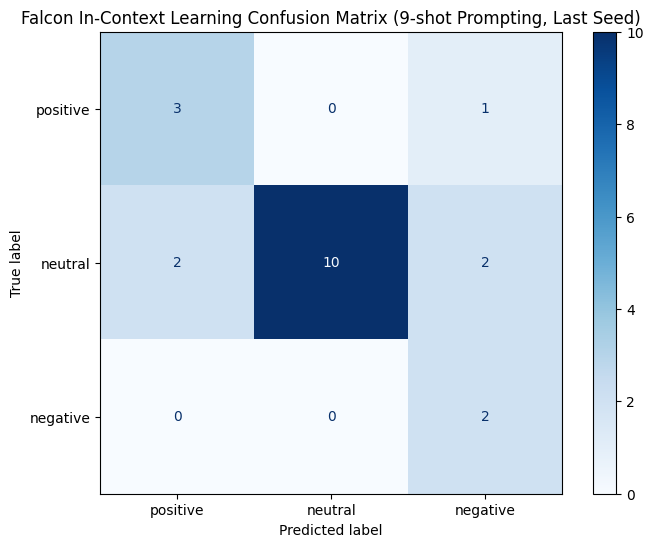

In [7]:
def sample_few_shot_balanced(df, shots_per_class=3, seed=42):
    sampled = []
    for label in ["positive", "neutral", "negative"]:
        subset = df[df["label_text"] == label]
        sampled.append(subset.sample(n=shots_per_class, random_state=seed))
    return pd.concat(sampled).sample(frac=1, random_state=seed).reset_index(drop=True)


seeds = [42, 99, 123, 2025, 7]
accuracies = []
f1_macros = []

for seed in seeds:
    few_shot = sample_few_shot_balanced(df, shots_per_class=3, seed=seed)

    preds = []
    for _, row in test_set.iterrows():
        prompt = build_prompt(few_shot, row["text"])
        response = generate_response(prompt)
        for label in ["positive", "neutral", "negative"]:
            if label in response:
                preds.append(label)
                break
        else:
            preds.append("unknown")

    # Save prediction to test set for the *last* seed
    if seed == seeds[-1]:
        test_set["predicted_label_9shot"] = preds

    true = test_set["label_text"]
    pred = preds
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro", zero_division=0)

    accuracies.append(acc)
    f1_macros.append(f1)

# Display average performance
print(f"Averaged over {len(seeds)} seeds:")
print(f"Mean Accuracy: {np.mean(accuracies):.2f}")
print(f"Mean Macro F1 Score: {np.mean(f1_macros):.2f}")

# Plot confusion matrix from last run
labels = ["positive", "neutral", "negative"]
cm = confusion_matrix(test_set["label_text"], test_set["predicted_label_9shot"], labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap="Blues", ax=ax)
plt.title("Falcon In-Context Learning Confusion Matrix (9-shot Prompting, Last Seed)")
plt.show()



## Shot Prompting Results

Averaging across five runs with different few-shot samples produced more stable performance. The model achieved a mean accuracy of approximately 82% and a macro F1 score of around 73%. Compared to the initial single-run result, this approach reduced variance and improved coverage across all sentiment classes, particularly for the underrepresented positive class. The final confusion matrix showed balanced predictions and confirmed that prompt diversity contributes to more reliable in-context learning.

Continuation back in [Main Notebook](../part1_finetuning_Distilbert.ipynb)